In [1]:
# import the necessary packages
from importlib import reload
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # ignore warnings
import nested.nested_dataframe as ndf
import json
from astropy.table import Table
import requests
from cosmicds.utils import API_URL
from hubbleds.utils import AGE_CONSTANT


In [2]:
from hubbleds.stages.stage_1 import StageState as Stage1State
from hubbleds.stages.stage_3 import StageState as Stage3State
from hubbleds.stages.stage_4 import StageState as Stage4State
from hubbleds.stages.stage_5 import StageState as Stage5State
from hubbleds.stages.stage_6 import StageState as Stage6State

stage1_markers = Stage1State().markers
stage3_markers = Stage3State().markers
stage4_markers = Stage4State().markers
stage5_markers = Stage5State().markers
stage6_markers = Stage6State().markers

In [3]:
from hubbleds.utils import HUBBLE_ROUTE_PATH


class State:
    
    
    stage1_markers = Stage1State().markers
    stage3_markers = Stage3State().markers
    stage4_markers = Stage4State().markers
    stage5_markers = Stage5State().markers
    stage6_markers = Stage6State().markers
    markers = {'0': None,
                    '1':stage1_markers,
                    '2': None,
                    '3':stage3_markers,
                    '4':stage4_markers,
                    '5':stage5_markers,
                    '6':stage6_markers}
    

    def __init__(self, story_state):
        # list story keys
        self.name = story_state['name'] # string
        self.title = story_state['title'] # string
        self.stages = {k:v['state'] for k,v in story_state['stages'].items()} #  dict_keys(['0', '1', '2', '3', '4', '5', '6'])
        self.classroom = story_state['classroom'] # dict_keys(['id', 'code', 'name', 'active', 'created', 'updated', 'educator_id', 'asynchronous'])
        self.responses = story_state['responses']
        self.mc_scoring = story_state['mc_scoring'] # dict_keys(['1', '3', '4', '5', '6'])
        self.stage_index = story_state['stage_index'] # int
        self.total_score = story_state['total_score'] #int
        self.student_user = story_state['student_user'] # dict_keys(['id', 'ip', 'age', 'lat', 'lon', 'seed', 'dummy', 'email', 'gender', 'visits', 'password', 'username', 'verified', 'last_visit', 'institution', 'team_member', 'last_visit_ip', 'profile_created', 'verification_code'])
        self.teacher_user = story_state['teacher_user'] # None
        self.max_stage_index = story_state['max_stage_index'] # int
        self.has_best_fit_galaxy = story_state['has_best_fit_galaxy'] # bool
        
    
    def get_possible_score(self):
        total_score = self.total_score
        possible_score = 0
        for key, value in self.mc_scoring.items():
            for v in value.values():
                possible_score += 10
        return possible_score
    
    def stage_score(self, stage):
        score = 0
        possible_score = 0
        for key, value in self.mc_scoring[str(stage)].items():
            score += value['score']
            possible_score += 10
        return score, possible_score
    

    @property
    def how_far(self):
        stage_index = self.max_stage_index
        stage_markers = self.markers[str(stage_index)]
        
        frac = self.stage_fraction_completed(stage_index)
        # are we in slideshow stage
        if stage_markers is None:
            string_fmt =  "In Stage {} slideshow".format(stage_index)
        else:
            string_fmt = f"{frac:.0%} through Stage {stage_index}"
            
        return {'string': string_fmt, 'value':frac}
    
    def stage_fraction_completed(self, stage):
        markers = self.markers[str(stage)]
        
        if markers is None:
            return 1.0
        current_stage_marker = self.stages[str(stage)]['marker']
        total = len(markers)
        current = markers.index(current_stage_marker) + 1
        frac = float(current) / float(total)
        return frac
    
    def total_fraction_completed(self):
        total = []
        current = []
        for key, stage in self.stages.items():
            markers = self.markers[key]
            if markers is not None:
                total.append(len(markers))
                if self.stage_index == int(key):
                    val = markers.index(self.current_marker) + 1
                elif self.max_stage_index > int(key):
                    # if true, then stage key is complete
                    val = len(markers)
                elif self.stage_index < int(key):
                    # if false, then stage key is not complete
                    val = 0 #markers.index(stage['marker']) + 1
                current.append(val)
        # print(total, current)
        frac = int(100 * float(sum(current)) / float(sum(total)))
        return {'percent':frac, 'total':sum(total), 'current':sum(current)}
    
    @property
    def possible_score(self):
        return self.get_possible_score()
    
    @property
    def score(self):
        return self.total_score / self.possible_score
    
    
    @property
    def current_marker(self):
        return self.stages[str(self.stage_index)].get('marker')
    
    @property
    def max_marker(self):
        return self.stages[str(self.max_stage_index)].get('marker')
    
    @property
    def percent_completion(self):
        return self.total_fraction_completed()['percent']
    
    
# create a wrapper class StateList that can be used to create a list of State objects
# and getattr to get the attributes of the State object
class StateList():
    
    def __init__(self, list_of_states):
        self.states = [State(state) for state in list_of_states]
    
    def __getattribute__(self, __name: str) -> list[State]:
        try:
            return object.__getattribute__(self, __name)
        except AttributeError:
            if __name == 'student_id' or __name == 'id':
                return [state.student_user['id'] for state in self.states]
            return [getattr(state, __name) for state in self.states]


In [5]:
# random dictionary
a = {'name': 'Hubble Deep Field', 'galaxy':'Yes'}
a.get('planet') is None

True

In [4]:
from matplotlib import markers
import requests
import requests
from cosmicds.utils import API_URL, CDSJSONEncoder
from hubbleds.utils import HUBBLE_ROUTE_PATH
import json

    
class QueryCosmicDSApi():
    
    url_head = API_URL
    querystring = {"":""}
    payload = ""
    headers = {"authority": "api.cosmicds.cfa.harvard.edu"}
    
    def __init__(self, story = None, class_id = None):
        self.class_id = class_id
        self.story = story
        pass
    
    def get(self,url):
        response = requests.request("GET", url)
        return response
        
    def get_roster(self, class_id = None, story = None):
        class_id = self.class_id or class_id
        story = self.story or story
        
        endpoint = f'roster-info/{class_id}'
        if (story is not None) and (story != ''):
            endpoint += f'/{story}'
        url = '/'.join([self.url_head, endpoint])
        self.roster_url = url
        req = self.get(url)
        return req.json()
    
    def get_student_data(self, student_id, story = None):
        story = self.story or story

        endpoint = f'{story}/measurements/{student_id}'
        url = '/'.join([self.url_head, endpoint])
        self.student_url = url
        req = self.get(url)
        try:
            return req.json()
        except json.JSONDecodeError:
            print(req.text)
            return None
    
    def get_class_data(self, class_id = None, student_ids = None, story = None):
        class_id = self.class_id or class_id
        story = self.story or story
        
        if (class_id is None) and (student_ids is None):
            return None
        
        if student_ids is None:
            roster = self.get_roster(class_id, story = story)
            student_ids = [student['student_id'] for student in roster]
            data = [self.get_student_data(student_id) for student_id in student_ids]
        else:
            if isinstance(student_ids, int):
                student_ids = [student_ids]
            data = [self.get_student_data(student_id) for student_id in student_ids]        
        return data
        


class Roster():
    
    def __init__(self, class_id = None):
        
        self.class_id = class_id
        self.query = QueryCosmicDSApi(class_id = class_id, story=HUBBLE_ROUTE_PATH)
        print('Getting roster')
        self.roster = self.query.get_roster()
        self.data = None
        
        if len(self.roster) == 0:
            return
        keys = self.roster[0].keys()
        new_out = self.l2d(self.roster)
        keys = new_out.keys()
        for key in keys:
            if isinstance(new_out[key][0],dict):
                new_out[key] = self.l2d(new_out[key])
            elif isinstance(new_out[key],list):
                new_out[key] = {key:new_out[key]}
            else:
                print(key, type(new_out[key][0]))
        
        self.student_id = new_out['student_id']
        self.story_name = new_out['story_name']
        self.story_state = new_out['story_state']
        
        
        
        self.stage1 = [s['state'] for s in self.l2d(self.story_state['stages'])['1']]
        self.stage2 = [s['state'] for s in self.l2d(self.story_state['stages'])['2']]
        self.stage3 = [s['state'] for s in self.l2d(self.story_state['stages'])['3']]
        self.stage4 = [s['state'] for s in self.l2d(self.story_state['stages'])['4']]
        self.stage5 = [s['state'] for s in self.l2d(self.story_state['stages'])['5']]
        self.stage6 = [s['state'] for s in self.l2d(self.story_state['stages'])['6']]
        
        
        self.stages = [
            self.stage1,
            self.stage3,
            self.stage4,
            self.stage5,
            self.stage6
        ]
        
        
        self.new_story_state = StateList([student['story_state'] for student in self.roster])
        self.last_modified = new_out['last_modified']
        self.stage_index = self.new_story_state.stage_index
        
        
        
        
        
        # mc_scores = self.l2d(self.story_state['mc_scores'])
        
        # df = pd.DataFrame.from_dict(self.students).set_index('student_id')
    

    
    def list_of_dicts_to_dict_of_lists(self, list_of_dicts):
        keys = list_of_dicts[0].keys()
        dict_of_lists = {k: [o[k] for o in list_of_dicts] for k in keys}
        return dict_of_lists
    
    def l2d(self, list_of_dicts):
        return self.list_of_dicts_to_dict_of_lists(list_of_dicts)

    def get_class_data(self):
        self.data = self.query.get_class_data(class_id = self.class_id, story = HUBBLE_ROUTE_PATH)
        
        measurements = []
        for student in self.data:
            for measurement in student['measurements']:
                measurements.append(measurement)
        return measurements
    
    def get_student_by_id(self, student_id):
        if student_id not in self.student_ids:
            print(f'{student_id} not in roster')
            return None
        return [student for student in self.roster if student['student_id'] == student_id][0]
    
    def make_dataframe(self, dictionary):
        # take the dictionary and make a dataframe
        # add self.student_ids as a column
        if 'student_id' not in dictionary.keys():
            dictionary['student_id'] = self.student_ids
        if isinstance(dictionary, pd.DataFrame):
            return dictionary.set_index('student_id')
        
        df = pd.DataFrame(dictionary).set_index('student_id')
        return df
    
    @property
    def student_ids(self):
        if len(self.roster) > 0:
            return [student['student_id'] for student in self.roster]
    
    @property
    def responses(self):
        if len(self.roster) > 0:
            df = pd.DataFrame([student['story_state']['responses'] for student in self.roster])
            return self.make_dataframe(ndf.flatten(df))
    
    
    @property
    def students(self):
        if len(self.roster) > 0:
            students = self.l2d([student['student'] for student in self.roster])
            return self.make_dataframe(students)
    
    @property
    def out_of(self):
        if len(self.roster) == 0:
            return
        out_of = []
        for mc_score in self.story_state['mc_scoring']:
            num = 0
            for key, val in mc_score.items():
                num += len(val)
            out_of.append(num * 10)
        return out_of
    
    def fraction_completed(self):
        # for each stage, create a state object using their story_state
        how_far = []
        tot_perc = []
        for student in self.roster:
            state = State(student['story_state'])
            how_far.append(state.how_far)
            tot_perc.append(state.percent_completion)
        return self.l2d(how_far)['string'], tot_perc
           


In [28]:
roster = Roster(class_id = 184)
data = [[s.get('marker',None) for s in stage] for stage in roster.stages]
cols = ['Stage 1 marker', 'Stage 3 marker', 'Stage 4 marker', 'Stage 5 marker', 'Stage 6 marker']
c1 = {k:v for k,v in zip(cols, data)}
response = ndf.flatten(pd.DataFrame(roster.story_state['responses']))
response['student_id'] = roster.student_id['student_id']
df = pd.DataFrame(c1)
df['student_id'] = roster.student_id['student_id']
df['username'] = roster.students['username']
completion_string, completion_percent = roster.fraction_completed()
df['progress'] = completion_string
df['percent_story_complete'] = completion_percent
# df['percent_story_complete'] = df['percent_story_complete'].apply(lambda x: int(x))
df['stage_index'] = roster.stage_index
df['total_score'] = roster.story_state['total_score']
df['out_of_possible'] = roster.out_of

df = df.merge(response, on='student_id', how='left')
last_modified = pd.to_datetime(roster.last_modified['last_modified']).tz_convert('US/Eastern').strftime("%Y-%m-%d %H:%M:%S (Eastern)") # in Easterm time
df['last_modified'] = last_modified

Getting roster


In [81]:
roster = Roster(class_id = 190)
roster.students

Getting roster


In [61]:
roster.query.get_roster(story=None)

[]

In [5]:
def create_report(class_id = 184, story = HUBBLE_ROUTE_PATH):
    roster = Roster(class_id = class_id)
    data = [[s.get('marker',None) for s in stage] for stage in roster.stages]
    cols = ['Stage 1 marker', 'Stage 3 marker', 'Stage 4 marker', 'Stage 5 marker', 'Stage 6 marker']
    c1 = {k:v for k,v in zip(cols, data)}
    response = ndf.flatten(pd.DataFrame(roster.story_state['responses']))
    response['student_id'] = roster.student_id['student_id']
    df = pd.DataFrame(c1)
    df['student_id'] = roster.student_id['student_id']
    df['username'] = roster.students['username']
    completion_string, completion_percent = roster.fraction_completed()
    df['progress'] = completion_string
    df['percent_story_complete'] = completion_percent
    # df['percent_story_complete'] = df['percent_story_complete'].apply(lambda x: int(x))
    df['stage_index'] = roster.stage_index
    df['total_score'] = roster.story_state['total_score']
    df['out_of_possible'] = roster.out_of

    df = df.merge(response, on='student_id', how='left')
    last_modified = pd.to_datetime(roster.last_modified['last_modified']).tz_convert('US/Eastern').strftime("%Y-%m-%d %H:%M:%S (Eastern)") # in Easterm time
    df['last_modified'] = last_modified
    return df

df = create_report(184, HUBBLE_ROUTE_PATH)




Getting roster


In [7]:
create_report(190)

Getting roster


AttributeError: 'Roster' object has no attribute 'stages'

In [74]:
df.to_excel('rogers_class_progress.xlsx')

In [37]:
data = roster.get_class_data()

In [39]:
data_df = pd.DataFrame(data)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns

In [42]:

def sigma_clip(x, y, sigma=3, iters=5):
    """
    Sigma clip data based off distance from best fit line.
    """
    clip = np.ones(len(x), dtype=bool)
    for i in range(iters):
        p = np.polyfit(x[clip], y[clip], 1)
        yfit = np.polyval(p, x)
        resid = y - yfit
        std = np.std(resid)
        indx = np.where(np.abs(resid) < sigma*std)
        clip_new = np.zeros(len(x), dtype=bool)
        clip_new[indx] = True
        print(i)
        if np.all(clip == clip_new):
            break
        clip = clip_new
    return clip

0
1
16.749354725365833
15.953749507908416


Text(0.05, 0.9, 'Age = 16.0 Gyr')

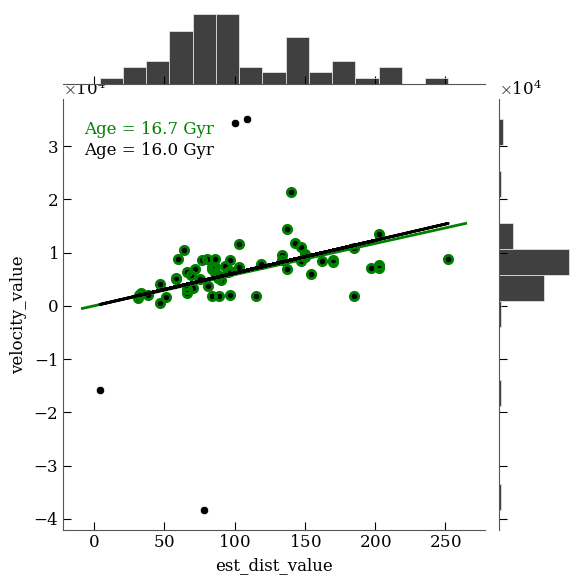

In [44]:
#using seaborn plot a jointplot of est_dist_value and velocity_value. color the points by the student_id column
# using the pandas dataframe data_df
g = sns.jointplot(x='est_dist_value', y='velocity_value', data=data_df, marginal_kws=dict(bins=15, rug=True), color='k')

x, y = data_df['est_dist_value'].values, data_df['velocity_value'].values
bad = np.isnan(x) | np.isnan(y)
x = x[~bad]
y = y[~bad]
clip = sigma_clip(x, y, sigma = 2)
def origin_slope(x, y):
    return np.sum(x*y)/np.sum(x**2)
slope = origin_slope(x[clip], y[clip])
print(AGE_CONSTANT / slope)
# add x and y to the sns jointplot
g.ax_joint.plot(x[clip], y[clip], 'ko', lw=2, mfc = 'none', mec = 'g', mew = 2)

# plot the best fit line for full range of x axis
# x axis limits
xlim = g.ax_joint.get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
# plot best fit line
g.ax_joint.plot(x, slope*x, 'g-', lw=2)

# add label with age to plot
age = AGE_CONSTANT / slope
g.ax_joint.text(0.05, 0.95, 'Age = {:.1f} Gyr'.format(age), transform=g.ax_joint.transAxes, va='top', ha='left', color='g')

# now do it for age without clipping
x, y = data_df['est_dist_value'].values, data_df['velocity_value'].values
bad = np.isnan(x) | np.isnan(y)
x = x[~bad]
y = y[~bad]
slope = origin_slope(x, y)
print(AGE_CONSTANT / slope)
# plot the best fit line
g.ax_joint.plot(x, slope*x, 'k-', lw=2)
# add label with age to plot
age = AGE_CONSTANT / slope
g.ax_joint.text(0.05, 0.9, 'Age = {:.1f} Gyr'.format(age), transform=g.ax_joint.transAxes, va='top', ha='left', color='k')



